## Experiment 1

### Part B

### Imports

In [1]:
# Cell 1: Import necessary libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import datetime

### Loading Data

In [2]:
# Cell 2: Load and preprocess datasets
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Preprocess the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Load the CIFAR-100 dataset
(x_train_cifar100, y_train_cifar100), (x_test_cifar100, y_test_cifar100) = tf.keras.datasets.cifar100.load_data()

# Preprocess the CIFAR-100 data
x_train_cifar100 = x_train_cifar100.astype('float32') / 255.0
x_test_cifar100 = x_test_cifar100.astype('float32') / 255.0

# Convert class vectors to binary class matrices for CIFAR-100
y_train_cifar100 = tf.keras.utils.to_categorical(y_train_cifar100, num_classes=100)
y_test_cifar100 = tf.keras.utils.to_categorical(y_test_cifar100, num_classes=100)

# Load the Tiny ImageNet dataset
# (You can use the provided Colab notebook link for Tiny ImageNet)
# Replace the following lines with the code to load and preprocess the Tiny ImageNet dataset
# ...

### Data augmentation

In [3]:
# Cell 3: Define data augmentation and data generators
# Define the data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Create a data generator for training data
batch_size = 32
train_generator_cifar10 = datagen.flow(x_train, y_train, batch_size=batch_size)
train_generator_cifar100 = datagen.flow(x_train_cifar100, y_train_cifar100, batch_size=batch_size)

### Creating custom function

In [4]:
# Cell 4: Define the function to build and train the transfer learning model
def build_and_train_model(base_model, dataset, num_classes):
    # Freeze the base model
    base_model.trainable = False

    # Add classification layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create the transfer learning model
    model = Model(inputs=base_model.input, outputs=outputs)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Define early stopping callbacks
    early_stopping_val_acc = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    early_stopping_train_acc = EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)

    # Train the model
    if dataset == 'cifar10':
        history = model.fit(train_generator_cifar10, epochs=10, validation_data=(x_test, y_test),
                            callbacks=[early_stopping_val_acc, early_stopping_train_acc], verbose=1)
    elif dataset == 'cifar100':
        history = model.fit(train_generator_cifar100, epochs=10, validation_data=(x_test_cifar100, y_test_cifar100),
                            callbacks=[early_stopping_val_acc, early_stopping_train_acc], verbose=1)
    # Add the condition for Tiny ImageNet dataset
    # ...

    # Evaluate the model
    if dataset == 'cifar10':
        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    elif dataset == 'cifar100':
        test_loss, test_acc = model.evaluate(x_test_cifar100, y_test_cifar100, verbose=0)
    # Add the condition for Tiny ImageNet dataset
    # ...

    print(f'Test accuracy for {dataset}: {test_acc * 100:.2f}%')

    return model, history, test_acc

### Load pre-trained models

In [5]:
# Cell 5: Load pre-trained models and custom model
# Load pre-trained models
vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Custom model
custom_model_path = '/Users/pc/Documents/UMKC/Spring 2024/Deep Learning/Project/Final Project/Final/models/cifar10_cnn_2_20240510003136.h5'
custom_model = tf.keras.models.load_model(custom_model_path)

### Executing VGG19 for CIFAR-10

In [6]:
# Cell 6a: Run experiments for VGG19 (CIFAR-10)
print("Running experiments for VGG19 (CIFAR-10)...")
dataset = 'cifar10'
num_classes = 10
model, history, test_acc = build_and_train_model(vgg19_model, dataset, num_classes)
models = []
histories = []
test_accuracies = []
models.append(model)
histories.append(history)
test_accuracies.append(test_acc)

Running experiments for VGG19 (CIFAR-10)...
Epoch 1/10
   1/1563 ━━━━━━━━━━━━━━━━━━━━ 13:21 513ms/step - accuracy: 0.0312 - loss: 2.4483

/Users/pc/anaconda3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 166s 106ms/step - accuracy: 0.3935 - loss: 1.7149 - val_accuracy: 0.5267 - val_loss: 1.3394
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 193s 123ms/step - accuracy: 0.4888 - loss: 1.4446 - val_accuracy: 0.5510 - val_loss: 1.2843
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 216s 138ms/step - accuracy: 0.5033 - loss: 1.4028 - val_accuracy: 0.5399 - val_loss: 1.2829
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 205s 131ms/step - accuracy: 0.5200 - loss: 1.3580 - val_accuracy: 0.5651 - val_loss: 1.2266
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 208s 133ms/step - accuracy: 0.5235 - loss: 1.3510 - val_accuracy: 0.5684 - val_loss: 1.2292
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 209s 134ms/step - accuracy: 0.5363 - loss: 1.3187 - val_accuracy: 0.5782 - val_loss: 1.2096
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 209s 134ms/step - accuracy: 0.5394 - loss: 1.3127 - val_accuracy: 0.5774 - val_loss: 1.1983
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 211s 135ms/step - accuracy: 0.5

### Executing VGG19 for CIFAR-100

In [7]:
# Cell 6b: Run experiments for VGG19 (CIFAR-100)
print("Running experiments for VGG19 (CIFAR-100)...")
dataset = 'cifar100'
num_classes = 100
model, history, test_acc = build_and_train_model(vgg19_model, dataset, num_classes)
models.append(model)
histories.append(history)
test_accuracies.append(test_acc)

Running experiments for VGG19 (CIFAR-100)...
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 216s 138ms/step - accuracy: 0.1162 - loss: 3.8908 - val_accuracy: 0.2458 - val_loss: 3.0776
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 214s 137ms/step - accuracy: 0.2184 - loss: 3.2375 - val_accuracy: 0.2753 - val_loss: 2.9063
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 214s 137ms/step - accuracy: 0.2364 - loss: 3.1097 - val_accuracy: 0.2832 - val_loss: 2.8582
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 240s 154ms/step - accuracy: 0.2504 - loss: 3.0285 - val_accuracy: 0.2984 - val_loss: 2.7971
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 254s 163ms/step - accuracy: 0.2589 - loss: 2.9821 - val_accuracy: 0.3018 - val_loss: 2.7875
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 249s 159ms/step - accuracy: 0.2658 - loss: 2.9369 - val_accuracy: 0.3145 - val_loss: 2.7372
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 213s 136ms/step - accuracy: 0.2705 - loss: 2.9168 - val_accuracy: 0.3155 - val_loss: 2.7268
Epoch 8/10
1563/1

### Executing ResNet for CIFAR-10

In [8]:
# Cell 6c: Run experiments for ResNet (CIFAR-10)
print("Running experiments for ResNet (CIFAR-10)...")
dataset = 'cifar10'
num_classes = 10
model, history, test_acc = build_and_train_model(resnet_model, dataset, num_classes)
models.append(model)
histories.append(history)
test_accuracies.append(test_acc)

Running experiments for ResNet (CIFAR-10)...
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 91s 57ms/step - accuracy: 0.1169 - loss: 2.3876 - val_accuracy: 0.1372 - val_loss: 2.2763
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 87s 56ms/step - accuracy: 0.1367 - loss: 2.2678 - val_accuracy: 0.2017 - val_loss: 2.1802
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 52ms/step - accuracy: 0.1501 - loss: 2.2319 - val_accuracy: 0.2077 - val_loss: 2.1738
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 53ms/step - accuracy: 0.1470 - loss: 2.2260 - val_accuracy: 0.2166 - val_loss: 2.1446
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 52ms/step - accuracy: 0.1575 - loss: 2.2111 - val_accuracy: 0.2238 - val_loss: 2.1404
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 53ms/step - accuracy: 0.1570 - loss: 2.2098 - val_accuracy: 0.2188 - val_loss: 2.1196
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 53ms/step - accuracy: 0.1567 - loss: 2.2064 - val_accuracy: 0.2259 - val_loss: 2.1230
Epoch 8/10
1563/1563 ━━━━━━━━━━

### Executing ResNet for CIFAR-100

In [9]:
# Cell 6d: Run experiments for ResNet (CIFAR-100)
print("Running experiments for ResNet (CIFAR-100)...")
dataset = 'cifar100'
num_classes = 100
model, history, test_acc = build_and_train_model(resnet_model, dataset, num_classes)
models.append(model)
histories.append(history)
test_accuracies.append(test_acc)

Running experiments for ResNet (CIFAR-100)...
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 84s 53ms/step - accuracy: 0.0104 - loss: 4.6617 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 84s 54ms/step - accuracy: 0.0103 - loss: 4.6056 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 52ms/step - accuracy: 0.0095 - loss: 4.6059 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 80s 51ms/step - accuracy: 0.0088 - loss: 4.6057 - val_accuracy: 0.0100 - val_loss: 4.6052
Test accuracy for cifar100: 1.00%


In [27]:
def train_resnet_cifar100():
    # Adjusted parameters
    learning_rate = 0.0001
    epochs = 20

    # Build ResNet model for CIFAR-100
    resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    # Freeze the base model
    resnet_model.trainable = False

    # Add classification layers
    x = resnet_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(100, activation='softmax')(x)

    # Create the transfer learning model
    model = Model(inputs=resnet_model.input, outputs=outputs)

    # Compile the model with adjusted learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    # Define early stopping callbacks
    early_stopping_val_acc = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    early_stopping_train_acc = EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(train_generator_cifar100, epochs=epochs, validation_data=(x_test_cifar100, y_test_cifar100),
                        callbacks=[early_stopping_val_acc, early_stopping_train_acc], verbose=1)

    # Evaluate the model
    test_loss, test_acc = model.evaluate(x_test_cifar100, y_test_cifar100, verbose=0)
    print(f'Test accuracy for CIFAR-100: {test_acc * 100:.2f}%')

    # Check if the new accuracy is higher than the previous one
    if test_acc > test_accuracies[-1]:
        # Replace the contents of ResNet for CIFAR-100 with the newest ones
        models[-1] = model
        histories[-1] = history
        test_accuracies[-1] = test_acc

# Call the custom function to train ResNet on CIFAR-100 with adjusted parameters
train_resnet_cifar100()


Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 39ms/step - accuracy: 0.0117 - loss: 4.8178 - val_accuracy: 0.0206 - val_loss: 4.5719
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 40ms/step - accuracy: 0.0192 - loss: 4.5761 - val_accuracy: 0.0255 - val_loss: 4.5257
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.0226 - loss: 4.5436 - val_accuracy: 0.0347 - val_loss: 4.4758
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 65s 41ms/step - accuracy: 0.0272 - loss: 4.5053 - val_accuracy: 0.0434 - val_loss: 4.4454
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 65s 42ms/step - accuracy: 0.0327 - loss: 4.4717 - val_accuracy: 0.0543 - val_loss: 4.4010
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 70s 44ms/step - accuracy: 0.0366 - loss: 4.4392 - val_accuracy: 0.0554 - val_loss: 4.3703
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 75s 48ms/step - accuracy: 0.0409 - loss: 4.4108 - val_accuracy: 0.0637 - val_loss: 4.3324
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 71s 45ms/step - accuracy: 0.0459 -

### Executing Custom Model for CIFAR-10

In [29]:
def run_custom_model_cifar10():
    print("Running experiments for custom model (CIFAR-10)...")
    dataset = 'cifar10'
    num_classes = 10

    # Load the custom model
    custom_model_path = '/Users/pc/Documents/UMKC/Spring 2024/Deep Learning/Project/Final Project/Final/models/cifar10_cnn_2_20240510003136.h5'
    custom_model = tf.keras.models.load_model(custom_model_path)

    # Check if the model is a Sequential model
    if isinstance(custom_model, tf.keras.Sequential):
        # Create a functional model equivalent to the Sequential model
        inputs = tf.keras.Input(shape=(32, 32, 3))
        x = inputs
        for layer in custom_model.layers:
            x = layer(x)
        model = tf.keras.Model(inputs=inputs, outputs=x)
    else:
        model = custom_model

    # Train and evaluate the custom model
    model, history, test_acc = build_and_train_model(model, dataset, num_classes)

    # Append the results to the existing lists
    models.append(model)
    histories.append(history)
    test_accuracies.append(test_acc)

# Call the custom function to run experiments with the custom model on CIFAR-10
run_custom_model_cifar10()


Running experiments for custom model (CIFAR-10)...
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.7408 - loss: 0.9896 - val_accuracy: 0.7740 - val_loss: 0.7439
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.7624 - loss: 0.7523 - val_accuracy: 0.7740 - val_loss: 0.7356
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.7660 - loss: 0.7297 - val_accuracy: 0.7759 - val_loss: 0.7107
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.7681 - loss: 0.7088 - val_accuracy: 0.7772 - val_loss: 0.7011
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.7652 - loss: 0.7065 - val_accuracy: 0.7737 - val_loss: 0.7088
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.7667 - loss: 0.7002 - val_accuracy: 0.7725 - val_loss: 0.7100
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.7654 - loss: 0.7003 - val_accuracy: 0.7749 - val_loss: 0.6978
Test accuracy for cifar10

### Executing Custom Model for CIFAR-100

In [30]:
def run_custom_model_cifar100():
    print("Running experiments for custom model (CIFAR-100)...")
    dataset = 'cifar100'
    num_classes = 100

    # Load the custom model
    custom_model_path = '/Users/pc/Documents/UMKC/Spring 2024/Deep Learning/Project/Final Project/Final/models/cifar10_cnn_2_20240510003136.h5'
    custom_model = tf.keras.models.load_model(custom_model_path)

    # Check if the model is a Sequential model
    if isinstance(custom_model, tf.keras.Sequential):
        # Create a functional model equivalent to the Sequential model
        inputs = tf.keras.Input(shape=(32, 32, 3))
        x = inputs
        for layer in custom_model.layers:
            x = layer(x)
        model = tf.keras.Model(inputs=inputs, outputs=x)
    else:
        model = custom_model

    # Train and evaluate the custom model
    model, history, test_acc = build_and_train_model(model, dataset, num_classes)

    # Append the results to the existing lists
    models.append(model)
    histories.append(history)
    test_accuracies.append(test_acc)

# Call the custom function to run experiments with the custom model on CIFAR-100
run_custom_model_cifar100()


Running experiments for custom model (CIFAR-100)...
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.0482 - loss: 4.3047 - val_accuracy: 0.0745 - val_loss: 4.0297
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.0680 - loss: 4.0735 - val_accuracy: 0.0799 - val_loss: 3.9905
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.0726 - loss: 4.0432 - val_accuracy: 0.0855 - val_loss: 3.9627
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.0719 - loss: 4.0217 - val_accuracy: 0.0881 - val_loss: 3.9340
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.0770 - loss: 3.9976 - val_accuracy: 0.0897 - val_loss: 3.9143
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.0820 - loss: 3.9788 - val_accuracy: 0.0906 - val_loss: 3.8897
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.0822 - loss: 3.9561 - val_accuracy: 0.0970 - val_loss: 3.8744
Epoch 8/10
1563/1563 ━━━

In [39]:
def run_custom_model_cifar100():
    print("Running experiments for custom model (CIFAR-100)...")
    dataset = 'cifar100'
    num_classes = 100

    # Load the custom model
    custom_model_path = '/Users/pc/Documents/UMKC/Spring 2024/Deep Learning/Project/Final Project/Final/models/cifar10_cnn_2_20240510003136.h5'
    custom_model = tf.keras.models.load_model(custom_model_path)

    # Check if the model is a Sequential model
    if isinstance(custom_model, tf.keras.Sequential):
        # Create a functional model equivalent to the Sequential model
        inputs = tf.keras.Input(shape=(32, 32, 3))
        x = inputs
        for layer in custom_model.layers:
            x = layer(x)
        # Modify the output layer to match the number of classes
        x = Dense(num_classes, activation='softmax')(x)
        model = tf.keras.Model(inputs=inputs, outputs=x)
    else:
        model = custom_model

    # Adjust hyperparameters and model architecture as needed
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Define early stopping callbacks
    early_stopping_val_acc = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    early_stopping_train_acc = EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(train_generator_cifar100, epochs=20, validation_data=(x_test_cifar100, y_test_cifar100),
                        callbacks=[early_stopping_val_acc, early_stopping_train_acc], verbose=1)

    # Train and evaluate the custom model
    model, history, test_acc = build_and_train_model(model, dataset, num_classes)

    # Check if the new accuracy is higher than the previous one
    if test_acc > test_accuracies[-1]:
        # Replace the contents of Custom model for CIFAR-100 with the newest ones
        models[-1] = model
        histories[-1] = history
        test_accuracies[-1] = test_acc

    # Append the results to the existing lists
    else:
        print("New accuracy is not higher than the previous one. Keeping the previous results.")

# Call the custom function to run experiments with the custom model on CIFAR-100
run_custom_model_cifar100()


Running experiments for custom model (CIFAR-100)...
Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 58s 37ms/step - accuracy: 0.0229 - loss: 4.5592 - val_accuracy: 0.0424 - val_loss: 4.4053
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 37ms/step - accuracy: 0.0415 - loss: 4.3904 - val_accuracy: 0.0439 - val_loss: 4.2687
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.0423 - loss: 4.2724 - val_accuracy: 0.0468 - val_loss: 4.1815
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 57s 36ms/step - accuracy: 0.0473 - loss: 4.1723 - val_accuracy: 0.0536 - val_loss: 4.0623
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.0555 - loss: 4.0656 - val_accuracy: 0.0597 - val_loss: 4.0021
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 70s 45ms/step - accuracy: 0.0636 - loss: 3.9653 - val_accuracy: 0.0709 - val_loss: 3.8807
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 71s 45ms/step - accuracy: 0.0707 - loss: 3.8777 - val_accuracy: 0.0761 - val_loss: 3.8039
Epoch 8/20
1563/1563 ━━━

### Tabulating the results

In [41]:
# Tabulate the results
results_df = pd.DataFrame({'Model': ['VGG19 (CIFAR-10)', 'VGG19 (CIFAR-100)',
                                     'ResNet (CIFAR-10)', 'ResNet (CIFAR-100)',
                                     'Custom (CIFAR-10)', 'Custom (CIFAR-100)'],
                            'Test Accuracy': test_accuracies})
print("\nResults:")
print(results_df)


Results:
                Model  Test Accuracy
0    VGG19 (CIFAR-10)         0.5739
1   VGG19 (CIFAR-100)         0.3207
2   ResNet (CIFAR-10)         0.2192
3  ResNet (CIFAR-100)         0.0902
4   Custom (CIFAR-10)         0.7772
5  Custom (CIFAR-100)         0.1693


### Tabulating and Visualising Results

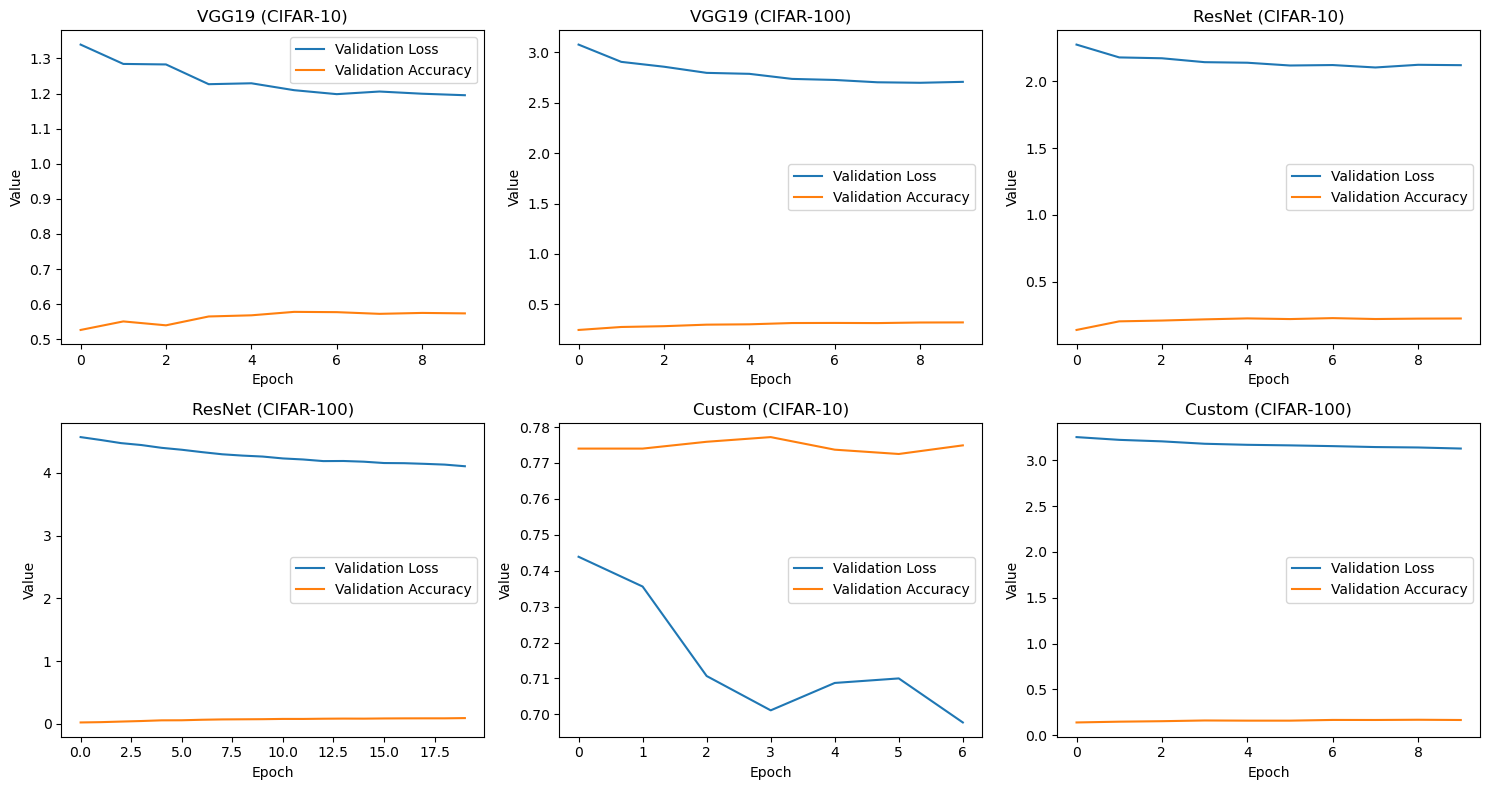

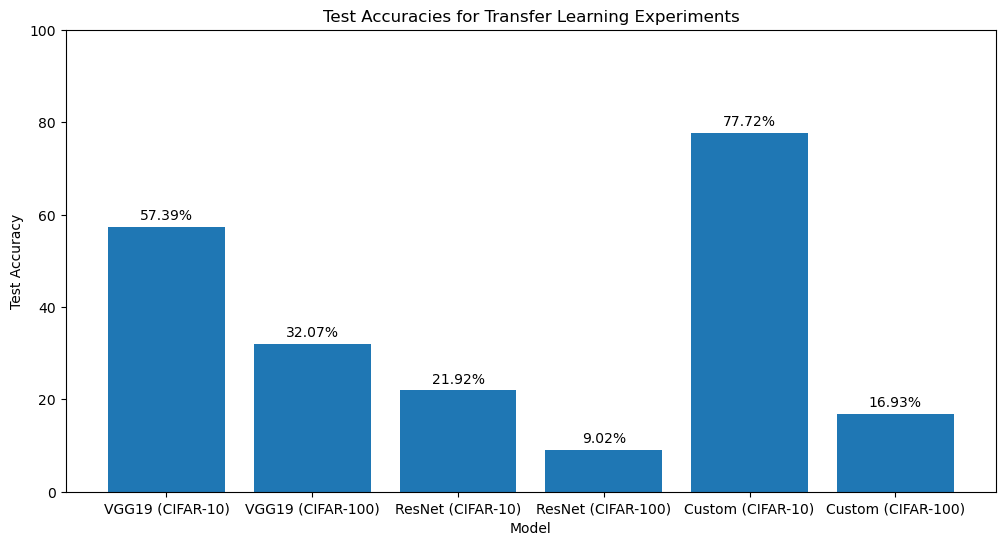

In [45]:
# Visualize results


# Visualize the validation loss and accuracy
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
for i, history in enumerate(histories):
    row = i // 3
    col = i % 3
    axs[row, col].plot(history.history['val_loss'], label='Validation Loss')
    axs[row, col].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[row, col].set_title(results_df.iloc[i]['Model'])
    axs[row, col].set_xlabel('Epoch')
    axs[row, col].set_ylabel('Value')
    axs[row, col].legend()

plt.tight_layout()
plt.show()

# Plot the test accuracies
# Create a bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(results_df['Model'], results_df['Test Accuracy']*100)
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracies for Transfer Learning Experiments')
plt.ylim(0, 100)  # Set y-axis limits to 0 and 1
plt.xticks(results_df['Model'])  # Set x-axis ticks to configuration numbers


# Add percentage labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.annotate('{:.2f}%'.format(height),
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')

### Exporting to CSV

In [47]:
# Cell 8: Export results to CSV
# Create a new folder for Experiment 2
experiment_folder = '/Users/pc/Documents/UMKC/Spring 2024/Deep Learning/Project/Final Project/Final/Experiment-2'
os.makedirs(experiment_folder, exist_ok=True)

# Create folders for models and CSV files within the Experiment 2 folder
models_folder = os.path.join(experiment_folder, 'models')
csv_folder = os.path.join(experiment_folder, 'csv_files')

# Create directories if they don't exist
os.makedirs(models_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)

# Export the results to a CSV file
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
csv_filename = f'Exp_1_Part_B_{timestamp}.csv'
csv_path = os.path.join(csv_folder, csv_filename)
results_df.to_csv(csv_path, index=False)

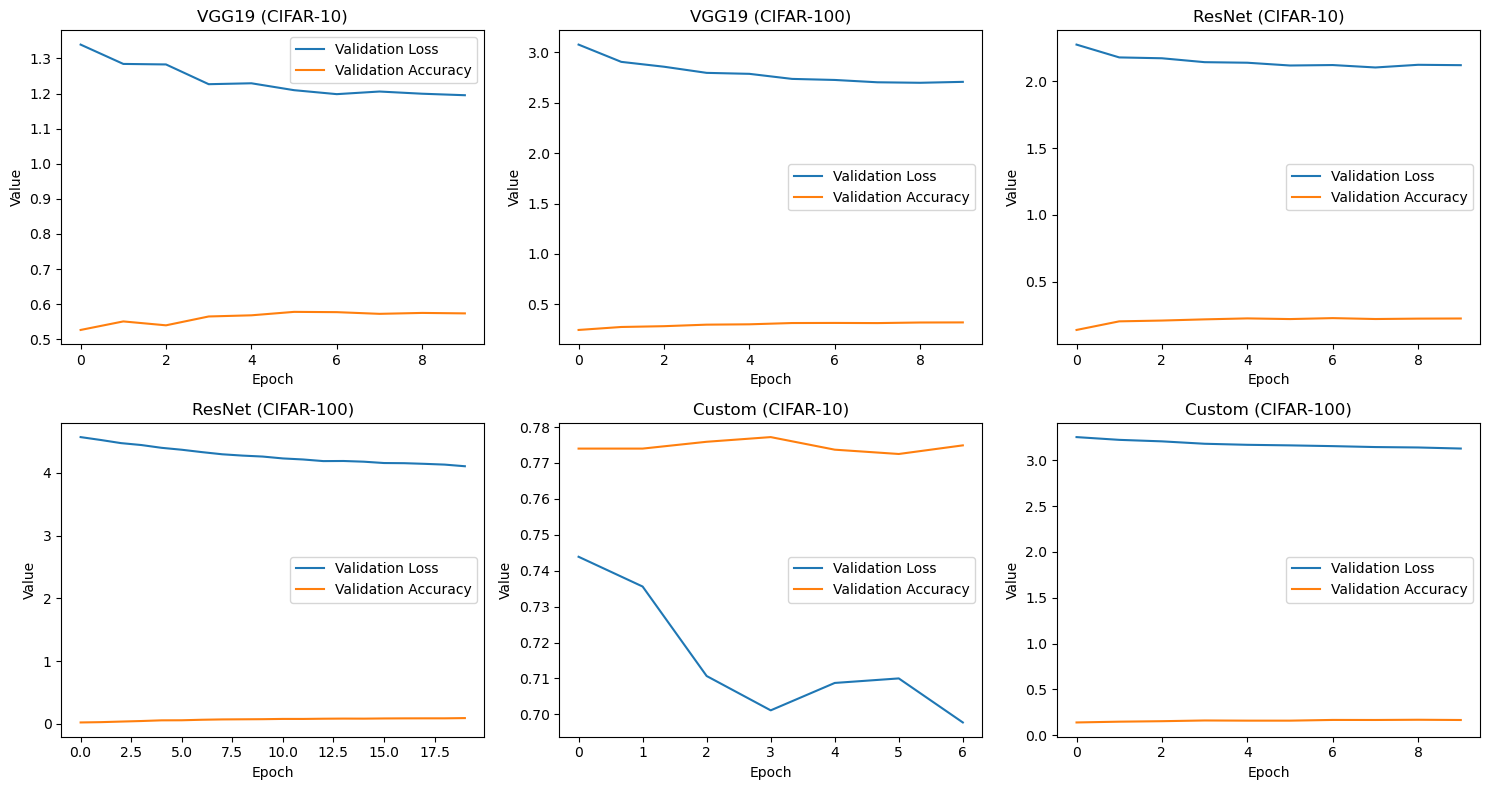

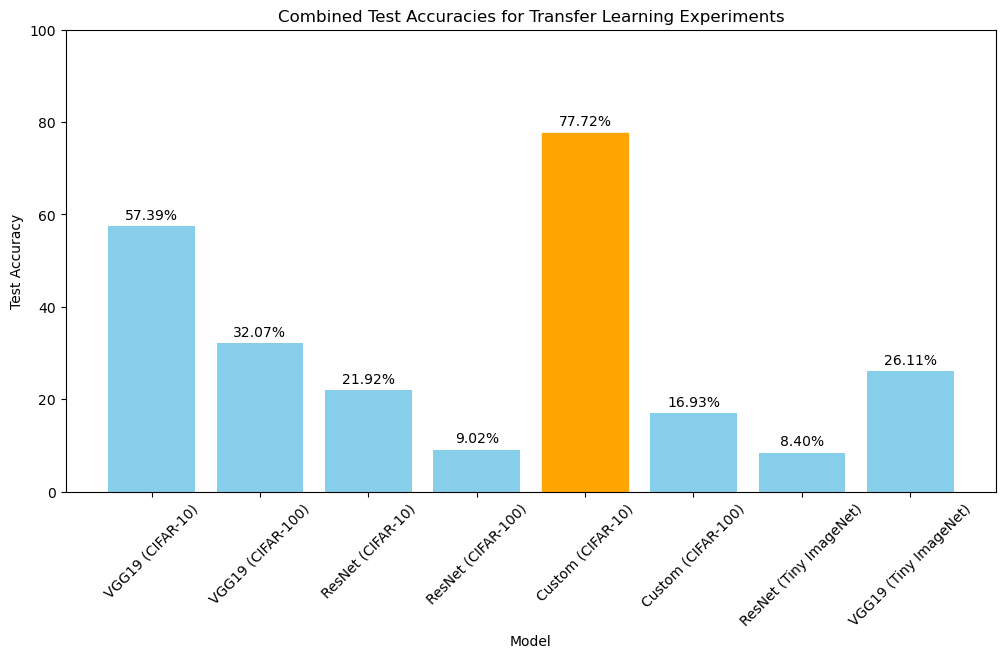

In [56]:
# Load additional CSV files
csv_file1 = "/Users/pc/Documents/UMKC/Spring 2024/Deep Learning/Project/Final Project/Part_A/Experiment_2/csv_files/Tiny_Imagenet_ResNET50_20240511193011.csv"
csv_file2 = "/Users/pc/Documents/UMKC/Spring 2024/Deep Learning/Project/Final Project/Part_A/Experiment_2/csv_files/Tiny_ImageNet_VGG19_results.csv"

# Read the CSV files
additional_results1 = pd.read_csv(csv_file1)
additional_results2 = pd.read_csv(csv_file2)

# Concatenate the additional results with the existing results
combined_results = pd.concat([results_df, additional_results1, additional_results2], ignore_index=True)

# Plot the combined results
# Visualize the validation loss and accuracy
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
for i, history in enumerate(histories):
    row = i // 3
    col = i % 3
    axs[row, col].plot(history.history['val_loss'], label='Validation Loss')
    axs[row, col].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[row, col].set_title(combined_results.iloc[i]['Model'])
    axs[row, col].set_xlabel('Epoch')
    axs[row, col].set_ylabel('Value')
    axs[row, col].legend()

plt.tight_layout()
plt.show()

# Find the model with the highest test accuracy
best_model_index = combined_results['Test Accuracy'].idxmax()

# Plot the combined test accuracies with the best model highlighted
plt.figure(figsize=(12, 6))
bars = plt.bar(combined_results['Model'], combined_results['Test Accuracy'] * 100, color='skyblue')  # Set default color for bars
bars[best_model_index].set_color('orange')  # Highlight the best model with a different color
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Combined Test Accuracies for Transfer Learning Experiments')
plt.ylim(0, 100)  # Set y-axis limits to 0 and 1
plt.xticks(rotation=45)
plt.xticks(combined_results['Model'])  # Set x-axis ticks to model names

# Add percentage labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.annotate('{:.2f}%'.format(height),
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')

# Show the plot
plt.show()


In [55]:
# Create a new folder for Experiment 2
experiment_folder = '/Users/pc/Documents/UMKC/Spring 2024/Deep Learning/Project/Final Project/Part_A/Experiment_2/csv_files'
os.makedirs(experiment_folder, exist_ok=True)


csv_folder = os.path.join(experiment_folder, 'csv_files')

# Create directories if they don't exist
os.makedirs(csv_folder, exist_ok=True)

# Export the combined results to a CSV file
combined_csv_filename = f'Final_Results_Part_B_{timestamp}.csv'
combined_csv_path = os.path.join(csv_folder, combined_csv_filename)
combined_results.to_csv(combined_csv_path, index=False)
